In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime
from statsmodels.regression.rolling import RollingOLS

# Data

In [2]:
his_members = pd.read_excel("../data/members.xlsx", sheet_name=1)
his_members.head()

,1980-03-31,1980-06-30,1980-09-30,1980-12-31,1981-03-31,1981-06-30,1981-09-30,1981-12-31,1982-03-31,1982-06-30,...,2020-09-30,2020-12-31,2021-03-31,2021-06-30,2021-09-30,2021-12-31,2022-03-31,2022-06-30,2022-09-30,2022-10-20
0,0111145D UN Equity,0111145D UN Equity,0111145D UN Equity,0111145D UN Equity,0111145D UN Equity,0111145D UN Equity,0111145D UN Equity,0111145D UN Equity,0111145D UN Equity,0111145D UN Equity,...,1981718D UW Equity,2061517D UW Equity,2061517D UW Equity,2150994D UW Equity,2150994D UW Equity,1950546D US Equity,2150994D UW Equity,2150994D UW Equity,A UN Equity,A UN Equity
1,0118113D UN Equity,0118113D UN Equity,0118113D UN Equity,0118113D UN Equity,0118113D UN Equity,0118113D UN Equity,0118113D UN Equity,0118113D UN Equity,0118113D UN Equity,0118113D UN Equity,...,2061517D UW Equity,2078185D UN Equity,2150994D UW Equity,9990213D UN Equity,9990213D UN Equity,2150994D UW Equity,9990213D UN Equity,9990213D UN Equity,AA UN Equity,AA UN Equity
2,0203524D UN Equity,0203524D UN Equity,0203524D UN Equity,0203524D UN Equity,0203524D UN Equity,0203524D UN Equity,0203524D UN Equity,0203524D UN Equity,0203524D UN Equity,0203524D UN Equity,...,2078185D UN Equity,2150994D UW Equity,9990213D UN Equity,9990253D UN Equity,9990253D UN Equity,9990213D UN Equity,9990253D UN Equity,A UN Equity,AAL UW Equity,AAL UW Equity
3,0226226D UN Equity,0226226D UN Equity,0226226D UN Equity,0226226D UN Equity,0226226D UN Equity,0226226D UN Equity,0226226D UN Equity,0226226D UN Equity,0226226D UN Equity,0226226D UN Equity,...,2150994D UW Equity,9990213D UN Equity,9990253D UN Equity,9990527D UW Equity,9990527D UW Equity,9990253D UN Equity,9990527D UW Equity,AA UN Equity,AAP UN Equity,AAP UN Equity
4,0544749D UN Equity,0544749D UN Equity,0544749D UN Equity,0544749D UN Equity,0544749D UN Equity,0544749D UN Equity,0544749D UN Equity,0544749D UN Equity,0544749D UN Equity,0544749D UN Equity,...,9990213D UN Equity,9990253D UN Equity,9990620D UN Equity,A UN Equity,A UN Equity,9990527D UW Equity,A UN Equity,AAL UW Equity,ACGL UW Equity,ACGL UW Equity


In [3]:
ave_ecoc = pd.read_excel("../clean_data/ave_ecoc_1117.xlsx", index_col=0)
FCFROIC_ADJ = pd.read_excel("../clean_data/FCFROIC_ADJ_yearly_0106.xlsx", index_col=0)
ave_ecoc.head()

,beta,name,DATES,GT10 Govt,rf,coe,10y_avg
183,1.138810,A,1994-06-30,7.319975,0.073200,0.141528,0.180326
184,1.133677,A,1994-07-29,7.110731,0.071107,0.139128,0.179694
185,1.110756,A,1994-08-31,7.173438,0.071734,0.138380,0.179047
186,1.106904,A,1994-09-30,7.603406,0.076034,0.142448,0.178495
187,1.110309,A,1994-10-31,7.806800,0.078068,0.144687,0.177961


In [4]:
ave_ecoc.index = ave_ecoc["DATES"]

In [5]:
ave_ecoc["Year"] = [date.year for date in ave_ecoc["DATES"]]
ave_ecoc_yearly = ave_ecoc.drop_duplicates(subset=["name", "Year"], keep="last").copy()
ave_ecoc_yearly.head()

,beta,name,DATES,GT10 Govt,rf,coe,10y_avg,Year
DATES,,,,,,,,
1994-12-30,1.050238,A,1994-12-30,7.821863,0.078219,0.141233,0.176938,1994
1995-02-28,1.021715,A,1995-02-28,7.201013,0.072010,0.133313,0.175897,1995
1996-12-31,0.873661,A,1996-12-31,6.417500,0.064175,0.116595,0.169741,1996
1997-12-31,1.102789,A,1997-12-31,5.741500,0.057415,0.123582,0.161052,1997
1998-12-31,0.958168,A,1998-12-31,4.648000,0.046480,0.103970,0.150691,1998


In [7]:
ave_ecoc_yearly["Ticker Symbol"] = ave_ecoc_yearly["name"]

In [8]:
all_data = FCFROIC_ADJ.merge(ave_ecoc_yearly, on=["Ticker Symbol", "Year"], how="outer")
all_data

,Year,Ticker Symbol,NYear,Cash & Short-Term Investments,Total Debt,Total Shareholder Equity,Total Invested Capital (Calculated),FCF,SIC,ROE,...,FCFROIC_ADJ,avg_fcfroic,avg_fcfroic_expanding,beta,name,DATES,GT10 Govt,rf,coe,10y_avg
0,1999,A,-23.0,789.0,0.0,4171.0,3382.0,27.0,3826.0,NaN,...,NaN,NaN,NaN,1.439147,A,1999-12-31,6.442000,0.064420,0.150769,0.146087
1,2000,A,-22.0,996.0,110.0,5265.0,4379.0,14.0,3826.0,NaN,...,NaN,NaN,NaN,1.566783,A,2000-12-29,5.111638,0.051116,0.145123,0.140849
2,2001,A,-21.0,1170.0,6.0,5659.0,4495.0,621.0,3826.0,NaN,...,NaN,NaN,NaN,1.955837,A,2001-12-31,5.051019,0.050510,0.167860,0.137815
3,2002,A,-20.0,1844.0,1150.0,4627.0,3933.0,-799.0,3826.0,NaN,...,NaN,NaN,NaN,2.061950,A,2002-12-31,3.815700,0.038157,0.161874,0.137857
4,2003,A,-19.0,1607.0,1150.0,2824.0,2367.0,-349.0,3826.0,NaN,...,NaN,NaN,NaN,2.213983,A,2003-12-31,4.247506,0.042475,0.175314,0.139912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46841,1995,WW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.350136,WW,1995-12-29,5.572331,0.055723,0.136731,0.141558
46842,1996,WW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.463487,WW,1996-04-30,6.670000,0.066700,0.154509,0.143905
46843,1984,WWE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.630080,WWE,1984-04-30,12.798460,0.127985,0.225789,0.085171
46844,2022,XLNX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.029830,XLNX,2022-01-31,1.778463,0.017785,0.079574,0.089531


In [9]:
all_data.to_excel("../clean_data/all_data_0106.xlsx")

In [44]:
q_ls = his_members.columns
q_ls_d = pd.to_datetime(q_ls)

ls = []
numbers = []
high_q_rate = []
low_q_rate = []
high_q_ls = []
low_q_ls = []

for i in range(his_members.shape[1]-1):
    m = his_members.iloc[:, i].dropna()
    quarter = datetime.strptime(m.name, "%Y-%m-%d")
    g = all_data[all_data["Year"] == quarter.year]

    m = m.str.extract(r'(\w+)')[0].values
    print(m)
    subset = g[g["Ticker Symbol"].isin(m)]
    subset["Quarter"] = quarter
    number = subset.shape[0]
    numbers.append(number)
    
    ls.append(subset)
    

quality = pd.concat(ls, ignore_index=True)
quality

['0111145D' '0118113D' '0203524D' '0226226D' '0544749D' '0574018D'
 '0616747D' '0872237D' '0882694D' '0910150D' '0932872D' '0948669D'
 '0961514D' '0975679D' '1013207D' '1030770Q' '1051665D' '1086832D'
 '118569Q' '119240Q' '1255177D' '1280712D' '1281118D' '1281683D'
 '1288652D' '1296456D' '1324741D' '140402Q' '1429716D' '1431816D'
 '1436513D' '1477070D' '1500785D' '1524867D' '1552309D' '1556464D'
 '156718Q' '1579957D' '1620366D' '1621582D' '1626714D' '1627472D'
 '1649858D' '166783Q' '1683351D' '1684442D' '1704453D' '1719868D'
 '1731877D' '1752754D' '1778808D' '1799685D' '1801229D' '1810430D'
 '1811934D' '1812212D' '1822785D' '1825471D' '1880942D' '1893675D'
 '191307Q' '1916526D' '1916672D' '1922150D' '1938073D' '1947467D'
 '1963166D' '1972693D' '1996074D' '1996760D' '2073714D' '2078185D'
 '2080733D' '208979Q' '2101674D' '2119228Q' '2250091Q' '2274839Q'
 '228510Q' '2307532Q' '235234Q' '236619Q' '2482718Q' '2676187Q' '2731112Q'
 '282996Q' '289416Q' '2942331Q' '2942695Q' '2953349Q' '297504

/Users/zhangzixin/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


['0111145D' '0118113D' '0203524D' '0226226D' '0544749D' '0574018D'
 '0616747D' '0872237D' '0882694D' '0910150D' '0932872D' '0948669D'
 '0961514D' '0975679D' '1013207D' '1030770Q' '1051665D' '1086832D'
 '118569Q' '119240Q' '1255177D' '1280712D' '1281118D' '1281683D'
 '1288652D' '1296456D' '1324741D' '140402Q' '1429716D' '1431816D'
 '1436513D' '1477070D' '1500785D' '1524867D' '1552309D' '1556464D'
 '156718Q' '1579957D' '1620366D' '1621582D' '1626714D' '1627472D'
 '1649858D' '166783Q' '1683351D' '1684442D' '1704453D' '1719868D'
 '1731877D' '1752754D' '1778808D' '1799685D' '1801229D' '1810430D'
 '1811934D' '1812212D' '1822785D' '1825471D' '1880942D' '1893675D'
 '191307Q' '1916526D' '1916672D' '1922150D' '1938073D' '1947467D'
 '1963166D' '1972693D' '1996074D' '1996760D' '2073714D' '2078185D'
 '2080733D' '208979Q' '2101674D' '2119228Q' '2250091Q' '2274839Q'
 '228510Q' '2307532Q' '235234Q' '236619Q' '2482718Q' '2676187Q' '2731112Q'
 '282996Q' '289416Q' '2942331Q' '2942695Q' '2953349Q' '297504

,Year,Ticker Symbol,NYear,Cash & Short-Term Investments,Total Debt,Total Shareholder Equity,Total Invested Capital (Calculated),FCF,SIC,ROE,...,avg_fcfroic,avg_fcfroic_expanding,beta,name,DATES,GT10 Govt,rf,coe,10y_avg,Quarter
0,1980,ADM,-42.0,125.745,228.867,766.971,870.093,NaN,2070.0,0.044289,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,1980-03-31
1,1980,AEE,-42.0,53.816,1621.641,1436.944,3004.769,NaN,4931.0,NaN,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,1980-03-31
2,1980,AEP,-42.0,80.460,5681.418,3969.701,9570.659,NaN,4911.0,NaN,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,1980-03-31
3,1980,AFG,-42.0,180.000,586.500,1395.200,1801.700,NaN,6331.0,0.011043,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,1980-03-31
4,1980,ALE,-42.0,1.004,414.959,336.584,750.539,NaN,4931.0,NaN,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,1980-03-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66540,2022,RL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.399277,RL,2022-03-31,2.340687,0.023407,0.107363,0.089334,2022-09-30
66541,2022,RPM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.922073,RPM,2022-03-31,2.340687,0.023407,0.078731,0.098036,2022-09-30
66542,2022,SJM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.262041,SJM,2022-03-31,2.340687,0.023407,0.039129,0.048526,2022-09-30
66543,2022,STE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.694922,STE,2022-03-31,2.340687,0.023407,0.065102,0.078105,2022-09-30


In [45]:
numbers

[182,
 182,
 182,
 182,
 184,
 184,
 184,
 184,
 196,
 196,
 196,
 196,
 210,
 210,
 210,
 210,
 266,
 266,
 266,
 266,
 221,
 221,
 221,
 221,
 237,
 237,
 237,
 237,
 245,
 245,
 245,
 245,
 252,
 252,
 252,
 252,
 258,
 258,
 258,
 258,
 259,
 259,
 259,
 259,
 267,
 267,
 267,
 267,
 276,
 276,
 276,
 276,
 287,
 287,
 287,
 287,
 330,
 330,
 330,
 330,
 346,
 346,
 346,
 346,
 357,
 357,
 357,
 357,
 355,
 355,
 355,
 355,
 366,
 366,
 366,
 366,
 377,
 377,
 377,
 377,
 371,
 420,
 416,
 412,
 407,
 396,
 397,
 394,
 390,
 449,
 449,
 450,
 449,
 441,
 440,
 438,
 437,
 421,
 424,
 423,
 424,
 396,
 396,
 394,
 387,
 384,
 380,
 380,
 383,
 400,
 402,
 402,
 401,
 456,
 456,
 452,
 448,
 471,
 470,
 475,
 472,
 461,
 463,
 465,
 464,
 467,
 465,
 470,
 472,
 497,
 498,
 501,
 501,
 462,
 463,
 476,
 479,
 504,
 508,
 518,
 515,
 492,
 498,
 503,
 499,
 516,
 514,
 523,
 517,
 551,
 549,
 548,
 547,
 562,
 564,
 564,
 563,
 602,
 609,
 609,
 612,
 664,
 675,
 680,
 684,
 678,
 685

In [11]:
q_ls = his_members.columns
q_ls

Index(['1980-03-31', '1980-06-30', '1980-09-30', '1980-12-31', '1981-03-31',
       '1981-06-30', '1981-09-30', '1981-12-31', '1982-03-31', '1982-06-30',
       ...
       '2020-09-30', '2020-12-31', '2021-03-31', '2021-06-30', '2021-09-30',
       '2021-12-31', '2022-03-31', '2022-06-30', '2022-09-30', '2022-10-20'],
      dtype='object', length=172)

In [12]:
quality["10y_ind"] = np.nan
quality.loc[(quality["avg_fcfroic"] >=
            quality["10y_avg"]), "10y_ind"] = 1
quality.loc[(quality["avg_fcfroic"] <
            quality["10y_avg"]), "10y_ind"] = 0
quality.to_excel("../clean_data/quantity_yearly_0106.xlsx")

In [40]:
low_q_num = quality[quality["10y_ind"] == 0].groupby("Year").count()["10y_ind"]
high_q_num = quality[quality["10y_ind"] == 1].groupby("Year").count()["10y_ind"]
num = quality.groupby("Year").count()["Ticker Symbol"]

In [39]:
quality.groupby("Year").count()

,Ticker Symbol,NYear,Cash & Short-Term Investments,Total Debt,Total Shareholder Equity,Total Invested Capital (Calculated),FCF,SIC,ROE,avg IC,...,avg_fcfroic_expanding,beta,name,DATES,GT10 Govt,rf,coe,10y_avg,Quarter,10y_ind
Year,,,,,,,,,,,,,,,,,,,,,
1980,728,728,604,664,664,604,0,724,148,40,...,0,0,0,0,0,0,0,0,728,0
1981,736,736,624,676,676,624,0,732,148,608,...,0,0,0,0,0,0,0,0,736,0
1982,784,784,676,724,724,676,0,780,160,672,...,0,0,0,0,0,0,0,0,784,0
1983,840,840,700,764,760,700,0,836,164,696,...,0,0,0,0,0,0,0,0,840,0
1984,1064,864,724,796,792,724,0,860,164,716,...,0,936,936,936,936,936,936,936,1064,0
1985,884,884,732,804,804,732,0,880,164,732,...,0,0,0,0,0,0,0,0,884,0
1986,948,948,744,836,836,744,0,944,168,740,...,0,0,0,0,0,0,0,0,948,0
1987,980,980,780,892,892,780,156,976,168,744,...,0,0,0,0,0,0,0,0,980,0
1988,1008,1008,808,940,940,808,688,1004,164,780,...,0,0,0,0,0,0,0,0,1008,0


In [41]:
num_all = pd.DataFrame()
num_all["high_q_num"] = high_q_num
num_all["low_q_num"] = low_q_num
num_all["total_num"] = num

In [42]:
num_all.to_excel("../clean_data/numbers_of_stocks_in_buckets.xlsx")

In [13]:
close_price = pd.read_excel("../data/stock_returns.xlsx")
close_price.head()

,Ticker,Monthly Calendar Date,Monthly Price,Monthly Price Date,Monthly Previous Price,Monthly Total Return
0,ACF,1961-01-31,50.250,1961-01-31,38.000,0.322368
1,ACF,1961-02-28,50.375,1961-02-28,50.250,0.014743
2,ACF,1961-03-30,54.750,1961-03-30,50.375,0.086849
3,ACF,1961-04-28,56.000,1961-04-28,54.750,0.022831
4,ACF,1961-05-31,59.750,1961-05-31,56.000,0.078315


In [15]:
close_price["q_pre_p"] = close_price["Monthly Price"].shift(3)
close_price["q_ret"] = close_price["Monthly Price"] / \
    close_price["q_pre_p"] - 1

# classification

In [28]:
FCFROIC_ADJ

,Year,Ticker Symbol,NYear,Cash & Short-Term Investments,Total Debt,Total Shareholder Equity,Total Invested Capital (Calculated),FCF,SIC,ROE,avg IC,FCFROIC,FCFROIC_ADJ,avg_fcfroic,avg_fcfroic_expanding
0,1999,A,-23,789.000,0.0,4171.000,3382.000,27.000,3826.0,NaN,3202.0000,0.008432,NaN,NaN,NaN
1,2000,A,-22,996.000,110.0,5265.000,4379.000,14.000,3826.0,NaN,3880.5000,0.003608,NaN,NaN,NaN
2,2001,A,-21,1170.000,6.0,5659.000,4495.000,621.000,3826.0,NaN,4437.0000,0.139959,NaN,NaN,NaN
3,2002,A,-20,1844.000,1150.0,4627.000,3933.000,-799.000,3826.0,NaN,4214.0000,-0.189606,NaN,NaN,NaN
4,2003,A,-19,1607.000,1150.0,2824.000,2367.000,-349.000,3826.0,NaN,3150.0000,-0.110794,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44741,2022,ZTS,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.15971,0.153209
44742,2012,ZU,-10,239.202,0.0,206.487,-32.715,8.425,5961.0,NaN,-24.1625,-0.348681,NaN,NaN,NaN
44743,2013,ZU,-9,308.103,0.0,242.203,-65.900,53.514,5961.0,0.079499,-49.3075,-1.085312,NaN,NaN,NaN
44744,2014,ZU,-8,373.820,0.0,275.963,-97.857,62.257,5961.0,0.040561,-81.8785,-0.760358,NaN,NaN,NaN


In [29]:
fcfroic_grouped = FCFROIC_ADJ.groupby("Year")


In [16]:
rate = pd.DataFrame()
rate["high_num"] = high_q_ls
rate["low_num"] = low_q_ls
rate["high_q"] = high_q_rate
rate["low_q"] = low_q_rate
rate.to_excel("../clean_data/summarized_rate_1218.xlsx")

In [17]:
quality.to_excel("../clean_data/quantity_1218.xlsx")

In [21]:
high_q = quality[quality["10y_ind"] == 1]
low_q = quality[quality["10y_ind"] == 0]

In [22]:
quality_grouped = quality.groupby(["Fiscal Year", "Fiscal Quarter"])
quality_grouped.mean().to_excel("../clean_data/summarized_data.xlsx")

In [23]:
quality_grouped = high_q.groupby(["Fiscal Year", "Fiscal Quarter"])
quality_grouped.mean().to_excel("../clean_data/summarized_data_high.xlsx")

quality_grouped = low_q.groupby(["Fiscal Year", "Fiscal Quarter"])
quality_grouped.mean().to_excel("../clean_data/summarized_data_low.xlsx")


In [20]:
date_idx = ave_ecoc.index.drop_duplicates()
date_idx = date_idx.sort_values()

def closest_p(dt):
    # datetime.strptime(dt, "%Y-%m-%d")
    return date_idx[date_idx >= dt][0]

## cal rolling return

In [24]:
def cal_rolling_ret(close_price):
    close_price["1y_rollingret"] = (
        close_price["Monthly Total Return"] + 1).rolling(12).apply(np.prod, raw=True) - 1
    close_price["3y_rollingret"] = (
        close_price["Monthly Total Return"] + 1).rolling(36).apply(np.prod, raw=True) - 1
    close_price["5y_rollingret"] = (
        close_price["Monthly Total Return"] + 1).rolling(60).apply(np.prod, raw=True) - 1
    return close_price

In [25]:
grouped = close_price.groupby("Ticker")
ls = []
for g in grouped:
    ticker = g[0]
    g = g[1][["Monthly Price Date", "Monthly Total Return"]]
    g["Ticker"] = ticker
    g = cal_rolling_ret(g)
    ls.append(g)
rolling_ret = pd.concat(ls, ignore_index=True)

/Users/zhangzixin/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [26]:
rolling_ret

,Monthly Price Date,Monthly Total Return,Ticker,1y_rollingret,3y_rollingret,5y_rollingret
0,1961-01-31,0.129310,A,NaN,NaN,NaN
1,1961-02-28,0.101781,A,NaN,NaN,NaN
2,1961-03-30,0.007103,A,NaN,NaN,NaN
3,1961-04-28,0.122685,A,NaN,NaN,NaN
4,1961-05-31,0.037113,A,NaN,NaN,NaN
...,...,...,...,...,...,...
656935,2015-05-29,0.060971,ZU,-0.619205,NaN,NaN
656936,2015-06-30,-0.013989,ZU,-0.681563,NaN,NaN
656937,2015-07-31,0.013037,ZU,-0.618429,NaN,NaN
656938,2015-08-31,0.343679,ZU,-0.458841,NaN,NaN


In [84]:
quality

,Year,Ticker Symbol,NYear,Cash & Short-Term Investments,Total Debt,Total Shareholder Equity,Total Invested Capital (Calculated),FCF,FCFROIC,avg IC,...,avg_fcfroic_expanding,beta,name,DATES,GT10 Govt,rf,coe,10y_avg,Quarter,10y_ind
0,1980,ADM,-42.0,125.745,228.867,766.971,870.093,NaN,NaN,NaN,...,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,1980-03-31,NaN
1,1980,AEE,-42.0,53.816,1621.641,1436.944,3004.769,NaN,NaN,NaN,...,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,1980-03-31,NaN
2,1980,AEP,-42.0,80.460,5681.418,3969.701,9570.659,NaN,NaN,NaN,...,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,1980-03-31,NaN
3,1980,AFG,-42.0,180.000,586.500,1395.200,1801.700,NaN,NaN,NaN,...,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,1980-03-31,NaN
4,1980,ALE,-42.0,1.004,414.959,336.584,750.539,NaN,NaN,NaN,...,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,1980-03-31,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66540,2022,RL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.399277,RL,2022-03-31,2.340687,0.023407,0.107363,0.089334,2022-09-30,NaN
66541,2022,RPM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.922073,RPM,2022-03-31,2.340687,0.023407,0.078731,0.098036,2022-09-30,NaN
66542,2022,SJM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.262041,SJM,2022-03-31,2.340687,0.023407,0.039129,0.048526,2022-09-30,NaN
66543,2022,STE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.694922,STE,2022-03-31,2.340687,0.023407,0.065102,0.078105,2022-09-30,NaN


In [83]:
# quality["close_date"] = quality["Quarter"].apply(closest_p)
quality_all = quality.merge(close_price_new, left_on=[
                            "Ticker Symbol", "Quarter"], right_on=[""])


In [18]:
grouped = close_price.groupby("Ticker")
ls = []
for _,group in grouped:
    group['q_pre_p'] = group["Monthly Price"].shift(3)
    group['q_ret'] = group["Monthly Price"]/group['q_pre_p'] - 1
    ls.append(group)
close_price_new = pd.concat(ls)

In [19]:
close_price_new.head()

,Ticker,Monthly Calendar Date,Monthly Price,Monthly Price Date,Monthly Previous Price,Monthly Total Return,q_pre_p,q_ret
8114,A,1961-01-31,49.125,1961-01-31,43.500,0.129310,NaN,NaN
8115,A,1961-02-28,54.125,1961-02-28,49.125,0.101781,NaN,NaN
8116,A,1961-03-30,54.000,1961-03-30,54.125,0.007103,NaN,NaN
8117,A,1961-04-28,60.625,1961-04-28,54.000,0.122685,49.125,0.234097
8118,A,1961-05-31,62.375,1961-05-31,60.625,0.037113,54.125,0.152425


In [20]:
quality_all = quality.merge(close_price_new[["Ticker", "Monthly Price Date", "q_ret"]], left_on=[
                            "Ticker Symbol", "Quarter"], right_on=["Ticker", "Monthly Price Date"])
quality_all

,Year,Ticker Symbol,NYear,Cash & Short-Term Investments,Total Debt,Total Shareholder Equity,Total Invested Capital (Calculated),FCF,SIC,ROE,...,DATES,GT10 Govt,rf,coe,10y_avg,Quarter,10y_ind,Ticker,Monthly Price Date,q_ret
0,1980,ADM,-42.0,125.745,228.867,766.971,870.093,NaN,2070.0,0.044289,...,NaT,NaN,NaN,NaN,NaN,1980-03-31,NaN,ADM,1980-03-31,-0.072874
1,1980,AEE,-42.0,53.816,1621.641,1436.944,3004.769,NaN,4931.0,NaN,...,NaT,NaN,NaN,NaN,NaN,1980-03-31,NaN,AEE,1980-03-31,-0.166667
2,1980,AEE,-42.0,53.816,1621.641,1436.944,3004.769,NaN,4931.0,NaN,...,NaT,NaN,NaN,NaN,NaN,1980-03-31,NaN,AEE,1980-03-31,-0.190476
3,1980,AEP,-42.0,80.460,5681.418,3969.701,9570.659,NaN,4911.0,NaN,...,NaT,NaN,NaN,NaN,NaN,1980-03-31,NaN,AEP,1980-03-31,-0.123288
4,1980,AFG,-42.0,180.000,586.500,1395.200,1801.700,NaN,6331.0,0.011043,...,NaT,NaN,NaN,NaN,NaN,1980-03-31,NaN,AFG,1980-03-31,-0.313514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47901,2022,RL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2022-03-31,2.340687,0.023407,0.107363,0.089334,2022-03-31,NaN,RL,2022-03-31,-0.045600
47902,2022,RPM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2022-03-31,2.340687,0.023407,0.078731,0.098036,2022-03-31,NaN,RPM,2022-03-31,-0.193663
47903,2022,SJM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2022-03-31,2.340687,0.023407,0.039129,0.048526,2022-03-31,NaN,SJM,2022-03-31,-0.003019
47904,2022,STE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2022-03-31,2.340687,0.023407,0.065102,0.078105,2022-03-31,NaN,STE,2022-03-31,-0.006738


In [87]:
quality_all.to_excel("../clean_data/quality_1218.xlsx")

## numbers

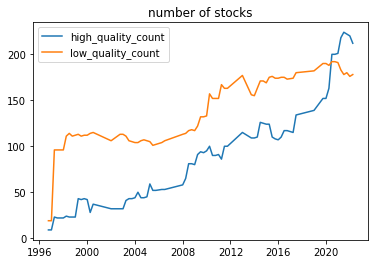

In [43]:
low_avg_count = quality_all[quality_all["10y_ind"]== 0].groupby("Quarter").count()["Ticker"]
high_avg_count = quality_all[quality_all["10y_ind"] == 1].groupby("Quarter").count()[
    "Ticker"]

avg_ret = pd.merge(high_avg_count, low_avg_count,
                   left_index=True, right_index=True)
avg_ret.columns = ["high_quality_count", "low_quality_count"]
plt.plot(avg_ret)
plt.legend(avg_ret.columns)
plt.title("number of stocks")
plt.savefig("../plot/avg_ret.png")

In [23]:
low_avg_ret = quality_all[quality_all["10y_ind"] == 0].groupby("Quarter").mean()[
    "q_ret"]
high_avg_ret = quality_all[quality_all["10y_ind"] == 1].groupby("Quarter").mean()[
    "q_ret"]

avg_ret = pd.merge(high_avg_ret, low_avg_ret,
                   left_index=True, right_index=True)
avg_ret.columns = ["high_quality_avg_ret", "low_quality_avg_ret"]
ave_ret_cum = (avg_ret + 1).cumprod()
ave_ret_cum.columns = ["high_quality_cumprod", "low_quality_cumprod"]
avg_ret_all = pd.merge(avg_ret, ave_ret_cum, left_index=True, right_index=True)
avg_ret_all.to_excel("../clean_data/avg_ret_all_0106.xlsx")

In [24]:
avg_ret.to_excel("../clean_data/quarterly_return_0106.xlsx")

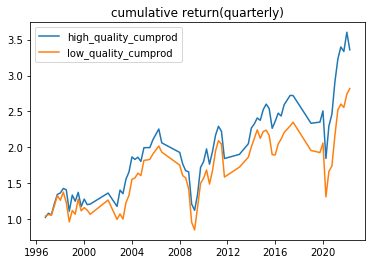

In [25]:
# ave_ret_cum.plot()
plt.plot(ave_ret_cum)
plt.legend(ave_ret_cum.columns)
plt.title("cumulative return(quarterly)")
plt.savefig("../plot/cumulative return.png")

In [26]:
avg_ret.merge(ave_ret_cum, left_index=True, right_index=True).to_excel("../clean_data/new_ret_0106.xlsx")

In [93]:
ave_ret_cum

,high_quality_cumprod,low_quality_cumprod
Quarter,,
1996-09-30,1.024908,1.040963
1996-12-31,1.084276,1.062299
1997-03-31,1.059398,1.054712
1997-06-30,1.207981,1.182894
1997-09-30,1.333429,1.327134
...,...,...
2021-03-31,2.987283,2.325005
2021-06-30,3.152748,2.415928
2021-09-30,3.097784,2.373174


In [33]:
def summary_stat(df, annual_factor, q=0.05):
    '''summary assets' mean return, voaltility(stdev) and sharpe ratio'''
    result = pd.DataFrame()
    result["mean"] = df.mean() * annual_factor
    result["volatility"] = df.std() * np.sqrt(annual_factor)
    result["Sharpe Ratio"] = result["mean"]/result["volatility"]

    result["VaR"] = df.quantile(q)
    return result

summary_stat(avg_ret, annual_factor=4)

,mean,volatility,Sharpe Ratio,VaR
high_quality_avg_ret,0.085966,0.198926,0.432148,-0.148765
low_quality_avg_ret,0.214946,0.624395,0.344247,-0.191652


In [ ]:
quality_all

,Global Company Key,Data Date,Fiscal Year,Fiscal Quarter,Ticker Symbol,FCFROIC,ROA,ROE,FCFROIC_ADJ,filtered,...,rf,coe,cost of equity,10y_avg,ind,close_date,Monthly Price Date,Ticker,q_ret_x,q_ret_y
0,9299,1987-12-31,1987,4.0,R,-0.154917,-0.004939,-0.020139,-0.154917,-0.154917,...,0.057656,0.136393,0.136393,0.155711,0,1987-12-31,1987-12-31,R,-0.273973,-0.273973
1,9299,1987-12-31,1987,4.0,R,-0.154917,-0.004939,-0.020139,-0.154917,-0.154917,...,0.057656,0.136393,0.136393,0.155711,0,1987-12-31,1987-12-31,R,-0.772727,-0.772727
2,10614,1987-12-31,1987,4.0,GL,0.225736,-0.024744,NaN,0.225736,0.225736,...,0.057656,0.117010,0.117010,0.138733,0,1987-12-31,1987-12-31,GL,-0.200000,-0.200000
3,9299,1988-03-31,1988,1.0,R,-0.044759,-0.005749,-0.023584,-0.044759,-0.044759,...,0.062058,0.135672,0.135672,0.154766,0,1988-03-31,1988-03-31,R,0.099057,0.099057
4,9299,1988-03-31,1988,1.0,R,-0.044759,-0.005749,-0.023584,-0.044759,-0.044759,...,0.062058,0.135672,0.135672,0.154766,0,1988-03-31,1988-03-31,R,-0.300000,-0.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31958,199356,2021-12-31,2021,4.0,TRIP,0.031386,-0.052163,-0.151611,0.031386,0.031386,...,0.000507,0.083073,0.083073,0.054006,1,2021-12-31,2021-12-31,TRIP,-0.194682,-0.194682
31959,260774,2021-12-31,2021,4.0,CBRE,0.183715,0.049038,0.118106,0.183715,0.183715,...,0.000507,0.084284,0.084284,0.114787,0,2021-12-31,2021-12-31,CBRE,0.114523,0.114523
31960,315318,2021-12-31,2021,4.0,ESI,0.062421,-0.024881,-0.051197,0.062421,0.062421,...,0.000507,0.081897,0.081897,0.121450,0,2021-12-31,2021-12-31,ESI,0.119926,0.119926
31961,316056,2021-12-31,2021,4.0,ALLE,0.202411,-0.039820,-0.150675,0.202411,0.202411,...,0.000507,0.062225,0.062225,0.050331,0,2021-12-31,2021-12-31,ALLE,0.001967,0.001967


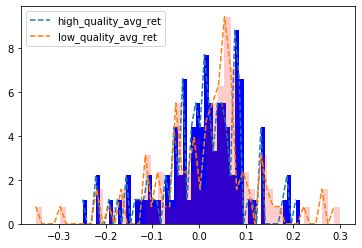

In [46]:
n1, bins1, patches1 = plt.hist(
    avg_ret.iloc[:, 0], bins=50, density=True, color='b', alpha=1)
n2, bins2, patches2 = plt.hist(
    avg_ret.iloc[:, 1], bins=50, density=True, color='r', alpha=0.2)

plt.plot(bins1[:-1], n1, '--')
plt.plot(bins2[:-1], n2, '--')
plt.legend(avg_ret.columns)

In [48]:
avg_ret.mean()/avg_ret.std()

high_quality_avg_ret    0.127573
low_quality_avg_ret     0.196831
dtype: float64

In [78]:
quality_all.columns

Index(['Global Company Key', 'Data Date', 'Fiscal Year', 'Fiscal Quarter',
       'Ticker Symbol', 'FCFROIC', 'ROA', 'ROE', 'FCFROIC_ADJ', 'filtered',
       'avg_fcfroic', 'avg_fcfroic_ajd', 'beta', 'TMBIDYTM', 'rf', 'coe',
       'cost of equity', '10y_avg', '10y_ind', 'ind', 'close_date',
       'Monthly Price Date', 'Ticker', 'Monthly Price'],
      dtype='object')

In [22]:
high_q_group = quality_all[quality_all["10y_ind"] == 1].groupby("Fiscal Year")
low_q_group = quality_all[quality_all["10y_ind"] == 0].groupby("Fiscal Year")
high_dict = {}
for g in high_q_group:
    y = g[0]
    g = g[1]
    high_dict[y] = g["Ticker"].drop_duplicates()

In [23]:
close_price = close_price.drop_duplicates(
    subset=["Ticker", "Monthly Calendar Date"])
close_price.sort_values(by=["Ticker", "Monthly Calendar Date"], inplace=True)

/Users/zhangzixin/opt/anaconda3/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [24]:
close_price

,Ticker,Monthly Calendar Date,Monthly Price,Monthly Price Date,Monthly Previous Price,Monthly Total Return,q_pre_p,q_ret
8114,A,1961-01-31,49.125,1961-01-31,43.500,0.129310,23.375,1.101604
8115,A,1961-02-28,54.125,1961-02-28,49.125,0.101781,23.500,1.303191
8116,A,1961-03-30,54.000,1961-03-30,54.125,0.007103,27.000,1.000000
8117,A,1961-04-28,60.625,1961-04-28,54.000,0.122685,49.125,0.234097
8118,A,1961-05-31,62.375,1961-05-31,60.625,0.037113,54.125,0.152425
...,...,...,...,...,...,...,...,...
58488,ZU,2015-05-29,13.225,2015-05-29,12.465,0.060971,14.010,-0.056031
58489,ZU,2015-06-30,13.040,2015-06-30,13.225,-0.013989,12.990,0.003849
58490,ZU,2015-07-31,13.210,2015-07-31,13.040,0.013037,12.465,0.059767
58491,ZU,2015-08-31,17.750,2015-08-31,13.210,0.343679,13.225,0.342155


In [25]:
close_price_u = rolling_ret
quality_all = pd.merge(quality, close_price_u, left_on=["close_date", "Ticker Symbol"],
                       right_on=["Monthly Price Date", "Ticker"], how="inner")
quality_all

,Global Company Key,Data Date,Fiscal Year,Fiscal Quarter,Ticker Symbol,FCFROIC_cal,avg_fcfroic,avg_fcfroic_expanding,beta,GT10 Govt,...,10y_avg,10y_ind,ind,close_date,Monthly Price Date,Monthly Total Return,Ticker,1y_rollingret,3y_rollingret,5y_rollingret
0,1161,1994-06-30,1994,2.0,AMD,-0.288028,NaN,NaN,1.622068,7.201381,...,0.202009,0,0,1994-06-30,1994-06-30,-0.074074,AMD,0.036269,1.083333,1.564103
1,1209,1994-06-30,1994,3.0,APD,0.051280,NaN,NaN,1.232546,7.201381,...,0.156832,0,0,1994-06-30,1994-06-30,0.008707,APD,0.103206,0.343975,1.093011
2,1246,1994-06-30,1994,3.0,IKN,0.029201,NaN,NaN,1.034703,7.201381,...,0.148176,0,0,1994-06-30,1994-06-30,-0.015086,IKN,0.194500,0.942477,1.147874
3,1380,1994-06-30,1994,2.0,HES,0.060205,NaN,NaN,0.455329,7.201381,...,0.140378,0,0,1994-06-30,1994-06-30,-0.002005,HES,0.017765,-0.004399,0.412299
4,1678,1994-06-30,1994,2.0,APA,-0.099357,NaN,NaN,0.906926,7.201381,...,0.152366,0,0,1994-06-30,1994-06-30,0.020991,APA,0.006214,0.952022,1.487586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32127,192255,2022-03-31,2022,1.0,ACHC,0.006485,-0.002705,-0.006037,1.460231,2.340687,...,0.066162,0,0,2022-03-31,2022-03-31,0.155528,ACHC,0.146832,1.235756,0.502982
32128,199356,2022-03-31,2022,1.0,TRIP,0.073770,0.196274,0.190735,1.320309,2.340687,...,0.115826,1,0,2022-03-31,2022-03-31,0.066038,TRIP,-0.495817,-0.407879,-0.294147
32129,260774,2022-03-31,2022,1.0,CBRE,-0.037810,0.014973,0.021440,1.417245,2.340687,...,0.139234,0,0,2022-03-31,2022-03-31,-0.055034,CBRE,0.156870,0.850758,1.630641
32130,315318,2022-03-31,2022,1.0,ESI,-0.003622,NaN,NaN,1.406285,2.340687,...,0.130204,0,0,2022-03-31,2022-03-31,-0.109032,ESI,0.211757,1.208144,0.712923


In [26]:
quality_all.to_excel("../clean_data/quality_n_1202.xlsx")

In [96]:
high_q = quality_all[quality_all["10y_ind"] == 1]
low_q = quality_all[quality_all["10y_ind"] == 0]
high_q.to_excel("../clean_data/highq_bucket_1223.xlsx")
low_q.to_excel("../clean_data/lowq_bucket_1223.xlsx")

In [94]:
rolling_ret.index = rolling_ret["Monthly Price Date"]
rolling_ret["year"] = [str(date.year) for date in rolling_ret["Monthly Price Date"]]

In [95]:
rolling_ret

,Monthly Price Date,Monthly Total Return,Ticker,1y_rollingret,3y_rollingret,5y_rollingret,year
Monthly Price Date,,,,,,,
1961-01-31,1961-01-31,0.129310,A,NaN,NaN,NaN,1961
1961-02-28,1961-02-28,0.101781,A,NaN,NaN,NaN,1961
1961-03-30,1961-03-30,0.007103,A,NaN,NaN,NaN,1961
1961-04-28,1961-04-28,0.122685,A,NaN,NaN,NaN,1961
1961-05-31,1961-05-31,0.037113,A,NaN,NaN,NaN,1961
...,...,...,...,...,...,...,...
2015-05-29,2015-05-29,0.060971,ZU,-0.619205,NaN,NaN,2015
2015-06-30,2015-06-30,-0.013989,ZU,-0.681563,NaN,NaN,2015
2015-07-31,2015-07-31,0.013037,ZU,-0.618429,NaN,NaN,2015


In [98]:
high_q_group = high_q.groupby("Year")
ls = []
for g in high_q_group:
    year = g[0]
    ticker = g[1]["Ticker Symbol"].drop_duplicates().values
    roll_ret = rolling_ret[(rolling_ret["year"] == str(year)) & (rolling_ret["Ticker"].isin(ticker))].groupby("Ticker").mean()
    roll_ret["Ticker"] = roll_ret.index
    roll_ret["Year"] = year
    ls.append(roll_ret)
high_ret_n = pd.concat(ls, ignore_index=True)

In [99]:
high_ret_n.to_excel("../clean_data/highq_bucket_rolling_is_1223.xlsx")

In [39]:
high_ret_n

,Monthly Total Return,1y_rollingret,3y_rollingret,5y_rollingret,Ticker,Year
0,0.001375,0.152641,0.462701,0.945171,SON,1996
1,0.019240,0.306904,0.899389,0.914488,BMS,1997
2,0.033766,0.468860,1.332953,2.864549,CSL,1997
3,0.056985,0.700036,0.851092,1.597455,HNI,1997
4,0.041839,0.207905,0.744442,1.307472,ITT,1997
...,...,...,...,...,...,...
2849,-0.057152,0.152743,0.308407,1.096407,WAT,2022
2850,-0.082450,-0.198656,0.117296,-0.290549,WDC,2022
2851,-0.000463,0.189968,1.204879,1.295989,WSO,2022
2852,0.084902,0.088444,-0.303083,1.882259,WWE,2022


In [100]:
low_q_group = low_q.groupby("Year")
ls = []
for g in low_q_group:
    year = g[0]
    ticker = g[1]["Ticker Symbol"].values
    high_ticker = set(high_ret_n[high_ret_n["Year"] == year].Ticker.values)
    ticker = list(set(ticker) - high_ticker)
    roll_ret = rolling_ret[(rolling_ret["year"] == str(year)) & (
        rolling_ret["Ticker"].isin(ticker))].groupby("Ticker").mean()
    roll_ret["Ticker"] = roll_ret.index
    roll_ret["Year"] = year
    ls.append(roll_ret)
low_ret_n = pd.concat(ls, ignore_index=True)
low_ret_n

,Monthly Total Return,1y_rollingret,3y_rollingret,5y_rollingret,Ticker,Year
0,0.004437,0.146857,0.613076,0.927198,BC,1996
1,0.060459,0.664615,0.923745,4.010923,BIG,1996
2,-0.001760,0.064113,0.089892,0.162732,HM,1996
3,0.009610,0.046093,0.174103,0.571395,LAF,1996
4,-0.007110,-0.072407,-0.319997,0.969580,LPX,1996
...,...,...,...,...,...,...
4290,0.024968,0.138619,0.388513,0.867486,XEL,2022
4291,-0.015129,0.058398,1.268986,1.582857,XPO,2022
4292,-0.039189,-0.063006,0.215658,-0.106157,XRAY,2022
4293,-0.032685,-0.090961,-0.234674,-0.131158,XRX,2022


In [101]:
low_ret_n.to_excel("../clean_data/lowq_bucket_rolling_is_1223.xlsx")

In [42]:
high_ret_n.groupby("Year").mean().to_excel("../clean_data/high_rolling_is_1218.xlsx")

In [43]:
low_ret_n.groupby("Year").mean().to_excel("../clean_data/low_rolling_is_1218.xlsx")

In [35]:
high_ret_n

,Monthly Total Return,1y_rollingret,3y_rollingret,5y_rollingret,Ticker,Year
0,0.039934,0.570213,0.757100,0.719886,GL,1997
1,0.028879,0.316696,0.873837,0.776350,KRI,1997
2,0.038145,0.380926,0.868550,1.521042,LNC,1997
3,0.059142,0.768035,2.249446,6.281677,MCK,1997
4,0.033755,0.401752,1.590249,3.373513,NOC,1997
...,...,...,...,...,...,...
1997,0.039511,-0.026313,0.173823,0.192181,WTM,2022
1998,0.000516,0.077793,0.414092,0.934285,WTW,2022
1999,0.021906,-0.167031,0.153880,0.140814,WU,2022
2000,-0.039189,-0.063006,0.215658,-0.106157,XRAY,2022


In [102]:
high_q_mean = high_ret_n.groupby("Year").mean()
low_q_mean = low_ret_n.groupby("Year").mean()
high_q_mean.to_excel("../clean_data/high_ret_is_1223.xlsx")

In [103]:
low_q_mean.to_excel("../clean_data/low_ret_is_1223.xlsx")